In [1]:
import pandas as pd
import numpy as np
import pycountry
import joblib
from computing_centroids import compute_centroids
import pickle
import re
import ast
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import gensim
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm
tqdm.pandas()
from datetime import datetime
from gensim.test.utils import get_tmpfile
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import country_converter as coco
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jahandelestangjim/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Clean and prepare the data

In [4]:
data=pd.read_csv('un_general_debates_extended.csv', index_col=0)
cc = coco.CountryConverter()
country_name_short=data['country_name_short']
un_region_names = cc.convert(names = country_name_short, to = 'UNregion')

data.loc[:,'UN_region']=un_region_names

# convert text data to lower case (for easier analysis)
data.loc[:,'text'] = data['text'].str.lower()
# Remove unusual symbols from description
def clean(s):    
    # Remove any tags:
    cleaned = re.sub(r"(?s)<.?>", " ", s)
    # Keep only regular chars:
    cleaned = re.sub(r"[^A-Za-z0-9(),*!?\'\`]", " ", cleaned)
    # Remove unicode chars
    cleaned = re.sub("\\\\u(.){4}", " ", cleaned)
    # Remove things between brackets
    cleaned = re.sub("\[.*?\]", " ", cleaned)

    return cleaned.strip()

# clean text
data.loc[:,'text'] = data.text.apply(lambda x: clean(x))
# remove data with null value in year column
data = data[data['year'].notnull()]


In [5]:
from nltk.tokenize import ToktokTokenizer
import string
from sklearn.feature_extraction import text
from functools import reduce
import pandas as pd
import unicodedata
import sys

tk = ToktokTokenizer()
# For replacement of contractions.
contractions = {"you'd": 'you would', "he'd": 'he would', "she's": 'she is', "where'd": 'where did', "might've": 'might have', "he'll": 'he will', "they'll": 'they will',  "mightn't": 'might not', "you'd've": 'you would have', "shan't": 'shall not', "it'll": 'it will', "mayn't": 'may not', "couldn't": 'could not', "they'd": 'they would', "so've": 'so have', "needn't've": 'need not have', "they'll've": 'they will have', "it's": 'it is', "haven't": 'have not', "didn't": 'did not', "y'all'd": 'you all would', "needn't": 'need not', "who'll": 'who will', "wouldn't've": 'would not have', "when's": 'when is', "will've": 'will have', "it'd've": 'it would have', "what'll": 'what will', "that'd've": 'that would have', "y'all're": 'you all are', "let's": 'let us', "where've": 'where have', "o'clock": 'oclock', "when've": 'when have', "what're": 'what are', "should've": 'should have', "you've": 'you have', "they're": 'they are', "aren't": 'are not', "they've": 'they have', "it'd": 'it would', "i'll've": 'i will have', "they'd've": 'they would have', "you'll've": 'you will have', "wouldn't": 'would not', "we'd": 'we would', "hadn't've": 'had not have', "weren't": 'were not', "i'd": 'i would', "must've": 'must have', "what's": 'what is', "mustn't've": 'must not have', "what'll've": 'what will have', "ain't": 'aint', "doesn't": 'does not', "we'll": 'we will', "i'd've": 'i would have', "we've": 'we have', "oughtn't": 'ought not', "you're": 'you are', "who'll've": 'who will have', "shouldn't": 'should not', "can't've": 'cannot have', "i've": 'i have', "couldn't've": 'could not have', "why've": 'why have', "what've": 'what have', "can't": 'cannot', "don't": 'do not', "that'd": 'that would', "who's": 'who is', "would've": 'would have', "there'd": 'there would', "shouldn't've": 'should not have', "y'all": 'you all', "mustn't": 'must not', "she'll": 'she will', "hadn't": 'had not', "won't've": 'will not have', "why's": 'why is', "'cause": 'because', "wasn't": 'was not', "shan't've": 'shall not have', "ma'am": 'madam', "hasn't": 'has not', "to've": 'to have', "how'll": 'how will', "oughtn't've": 'ought not have', "he'll've": 'he will have', "we'd've": 'we would have', "won't": 'will not', "could've": 'could have', "isn't": 'is not', "she'll've": 'she will have', "we'll've": 'we will have', "you'll": 'you will', "who've": 'who have', "there's": 'there is', "y'all've": 'you all have', "we're": 'we are', "i'll": 'i will', "i'm": 'i am', "how's": 'how is', "she'd've": 'she would have', "sha'n't": 'shall not', "there'd've": 'there would have', "he's": 'he is', "it'll've": 'it will have', "that's": 'that is', "y'all'd've": 'you all would have', "he'd've": 'he would have', "how'd": 'how did', "where's": 'where is', "so's": 'so as', "she'd": 'she would', "mightn't've": 'might not have'}
un_stopwords = ['nations','year','believe','important','assembly','secretary',
                'conference', 'like', 'way', 'state', 'resolution', 
                'government', 'make', 'role', 
                'united nation', 'united nations', 'general assembly', 'republic of', 'secretary general', 'the world', 
                'ibid', 'security council', 'member state', 'country', 'must', 'many'] + list(text.ENGLISH_STOP_WORDS)

def tokenize_text(text, stopwords=un_stopwords):
    text = reduce(lambda a, kv: a.replace(*kv), contractions.items(), text.lower())
    text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    tokens = tk.tokenize(text)
    
    tokens = [token for token in tokens if len(token) > 3 and
             token not in stopwords and not token.isdigit()]
    
    #remove inflectional endings and get the root word (lemma):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    
    return lemmas

data['clean_text'] = data['text'].apply(tokenize_text)

In [6]:
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess

# Create a Phrases model to detect common bigrams
bigram_model = Phrases(data['clean_text'].values, min_count=3, threshold=2)

# Convert the bigrams into single tokens
phraser = Phraser(bigram_model)
processed_sentences = [phraser[sentence] for sentence in data['clean_text'].values]
data['clean_text']=processed_sentences
data.to_csv('un_general_debates_extended_cleaned.csv')

In [6]:
data=pd.read_csv('un_general_debates_extended_cleaned.csv', index_col=0)
data['clean_text'] = data['clean_text'].apply(ast.literal_eval)
data

,country,text,year,country_name_short,UN_region,clean_text
0,CHL,I shall occupy this rostrum for a few minutes ...,1946,Chile,South America,"[shall, occupy, rostrum, minute, order, genera..."
1,COL,The Colombian delegation does not consider it ...,1946,Colombia,South America,"[colombian_delegation, doe_consider, necessary..."
2,BLR,As more than a year has elapsed since the Unit...,1946,Belarus,Eastern Europe,"[elapsed, united_charter, signed_francisco, po..."
3,IND,I stand before this great Assembly — unique in...,1946,India,Southern Asia,"[stand, great, unique_annals, human_history, r..."
4,GBR,"In his great pronouncement here the other day,...",1946,United Kingdom,Northern Europe,"[great, pronouncement, president_truman, used,..."
...,...,...,...,...,...,...
10563,GAB,"It is my pleasant duty to offer you, Mr. Presi...",1963,Gabon,Middle Africa,"[pleasant_duty, offer, president_behalf, gabon..."
10564,TCD,"It Is not without a certain pride, mixed with ...",1963,Chad,Middle Africa,"[certain, pride, mixed, speak_behalf, brings, ..."
10565,COL,"Colombia, and the delegation which represents ...",1963,Colombia,South America,"[colombia, delegation, represents, particularl..."
10566,TUN,"Mr. President, it is a pleasure for me first o...",1963,Tunisia,Northern Africa,"[president, pleasure_offer, behalf_behalf, tun..."


In [7]:
from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance

# Sample dataset - a list of documents
documents = data['clean_text'].values
documents = [" ".join(sublist) for sublist in documents]

# Create your representation model
representation_model = MaximalMarginalRelevance(diversity=0.3)

# Use the representation model in BERTopic on top of the default pipeline
topic_model = BERTopic(representation_model=representation_model, nr_topics="auto")

# Fit the model on the dataset
topics, probabilities = topic_model.fit_transform(documents)
new_topics = topic_model.reduce_outliers(documents, topics, probabilities=probabilities, strategy="probabilities")

topic_model.update_topics(documents, topics=new_topics)


2024-06-07 14:04:38,777 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [9]:
# Get the topics and display them
print("Topics and their frequency:")
topic_freq = topic_model.get_topic_info()
print(topic_freq)

# Display the words associated with each topic
for topic_id in topic_freq['Topic']:
    topic_details = topic_model.get_topic(topic_id)
    print(f"\nTopic {topic_id}:")
    print(topic_details)

Topics and their frequency:
     Topic  Count                                               Name  \
0        0   5943                      0_united_world_people_country   
1        1    234           1_pandemic_covid_covidpandemic_president   
2        2    157        2_sovietunion_unitedstate_state_disarmament   
3        3    125                  3_israel_palestinian_israeli_iran   
4        4    123        4_kuwait_kingdombahrain_world_international   
..     ...    ...                                                ...   
142    142     11  142_montenegro_montenegrosupport_montenegrostr...   
143    143     11  143_democraticpeople_republickorea_tiirkiye_un...   
144    144     10                  144_denmark_danish_united_general   
145    145     10                   145_jordan_arab_jordanian_israel   
146    146     10          146_uruguay_international_country_zealand   

                                        Representation  \
0    [united, world, people, country, internation

In [10]:
topics_to_merge = [
    128, 134, 137, 140, 143, 51, 54,57, 62,63, 72, 74, 79, 85, 96, 0, 2, 3,4,5,8,10,14,17,18,21,25,26,28,30,34,35,38,41,43, 100, 101, 103, 105, 109, 118
]
topic_model.merge_topics(documents, topics_to_merge)

In [11]:
# Get the topics and display them
print("Topics and their frequency:")
topic_freq = topic_model.get_topic_info()
print(topic_freq)

# Display the words associated with each topic
for topic_id in topic_freq['Topic']:
    topic_details = topic_model.get_topic(topic_id)
    print(f"\nTopic {topic_id}:")
    print(topic_details)

Topics and their frequency:
     Topic  Count                                               Name  \
0        0   7516                      0_united_world_people_country   
1        1    234           1_pandemic_covid_covidpandemic_president   
2        2     63           2_bruneidarussalam_region_united_country   
3        3     54                     3_lebanon_lebanese_israel_arab   
4        4     52         4_peru_peruvian_international_latinamerica   
..     ...    ...                                                ...   
102    102     11       102_maldives_climatechange_smallstate_united   
103    103     11  103_montenegro_montenegrosupport_montenegrostr...   
104    104     10            104_uruguay_international_country_world   
105    105     10                  105_denmark_danish_united_general   
106    106     10                   106_jordan_arab_israel_jordanian   

                                        Representation  \
0    [united, world, people, country, internation

In [14]:
data['Topic']=topic_model.get_document_info(documents)['Topic']
data=data[data['Topic']==0]
data

,country,text,year,country_name_short,UN_region,clean_text,Topic
0,CHL,I shall occupy this rostrum for a few minutes ...,1946,Chile,South America,"[shall, occupy, rostrum, minute, order, genera...",0.0
1,COL,The Colombian delegation does not consider it ...,1946,Colombia,South America,"[colombian_delegation, doe_consider, necessary...",0.0
2,BLR,As more than a year has elapsed since the Unit...,1946,Belarus,Eastern Europe,"[elapsed, united_charter, signed_francisco, po...",0.0
4,GBR,"In his great pronouncement here the other day,...",1946,United Kingdom,Northern Europe,"[great, pronouncement, president_truman, used,...",0.0
5,MEX,Our presence in New York affords objective pro...,1946,Mexico,Central America,"[presence_york, affords, objective, proof, con...",0.0
...,...,...,...,...,...,...,...
10549,ROU,"Mr. President, I would like first of all to as...",1963,Romania,Eastern Europe,"[president_associate, previous_speaker, congra...",0.0
10550,ARG,"Mr. President, I wish, first, to convey to you...",1963,Argentina,South America,"[president, wish_convey, warmest_congratulatio...",0.0
10551,KWT,This is the first regular session of the Gener...,1963,Kuwait,Western Asia,"[regular_session, general, kuwait_honoured, at...",0.0
10553,PAN,I should like to begin my statement by express...,1963,Panama,Central America,"[begin_statement, expressing_deep, heartfelt, ...",0.0


In [15]:
# Sample dataset - a list of documents
documents = data['clean_text'].values
documents = [" ".join(sublist) for sublist in documents]

# Create your representation model
representation_model = MaximalMarginalRelevance(diversity=0.3)

# Use the representation model in BERTopic on top of the default pipeline
topic_model = BERTopic(representation_model=representation_model, nr_topics="auto")

# Fit the model on the dataset
topics, probabilities = topic_model.fit_transform(documents)
new_topics = topic_model.reduce_outliers(documents, topics, probabilities=probabilities, strategy="probabilities")

topic_model.update_topics(documents, topics=new_topics)

2024-06-07 15:14:35,653 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [27]:
# Get the topics and display them
print("Topics and their frequency:")
topic_freq = topic_model.get_topic_info()
print(topic_freq)

# Display the words associated with each topic
for topic_id in topic_freq['Topic']:
    topic_details = topic_model.get_topic(topic_id)
    print(f"\nTopic {topic_id}:")
    print(topic_details)

Topics and their frequency:
   Topic  Count                                 Name  \
0      0   7176        0_united_world_people_country   
1      1    128  1_united_world_people_international   
2      2    111          2_united_people_world_peace   
3      3     92       3_united_pandemic_world_global   

                        CustomName  \
0          Country-specific topics   
1                  Regional topics   
2                    Global issues   
3  Historical events and conflicts   

                                      Representation  \
0  [united, world, people, country, international...   
1  [united, world, people, international, peace, ...   
2  [united, people, world, peace, state, country,...   
3  [united, pandemic, world, global, country, pre...   

                                 Representative_Docs  
0  [country term charter special_responsibility l...  
1  [president_behalf delegation_thailand pleased_...  
2  [president_behalf delegation soviet_union cong...  

In [19]:
list_of_lists=[[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 20, 21, 22, 23, 24, 25, 26, 27, 29, 31, 32, 33, 34, 37, 38, 39, 41, 44, 47, 48, 49, 50, 51, 52, 54], 
[19, 28, 40, 42, 43, 46, 53], 
[2, 35], 
[16, 17, 30, 36, 45]
]
topics_to_merge = list_of_lists
topic_model.merge_topics(documents, topics_to_merge)

In [20]:
topic_model.set_topic_labels({0: "Country-specific topics", 1: 'Regional topics', 
                              2: 'Global issues', 3:'Historical events and conflicts'})

In [24]:
data['Topic']=topic_model.get_document_info(documents)['Topic']
data['topics_name']=topic_model.get_document_info(documents)['CustomName']
data.to_csv('un_general_debates_extended_cleaned_topics_international_relations.csv')
data

,country,text,year,country_name_short,UN_region,clean_text,Topic,topics_name
0,CHL,I shall occupy this rostrum for a few minutes ...,1946,Chile,South America,"[shall, occupy, rostrum, minute, order, genera...",0.0,Country-specific topics
1,COL,The Colombian delegation does not consider it ...,1946,Colombia,South America,"[colombian_delegation, doe_consider, necessary...",0.0,Country-specific topics
2,BLR,As more than a year has elapsed since the Unit...,1946,Belarus,Eastern Europe,"[elapsed, united_charter, signed_francisco, po...",0.0,Country-specific topics
4,GBR,"In his great pronouncement here the other day,...",1946,United Kingdom,Northern Europe,"[great, pronouncement, president_truman, used,...",0.0,Country-specific topics
5,MEX,Our presence in New York affords objective pro...,1946,Mexico,Central America,"[presence_york, affords, objective, proof, con...",0.0,Country-specific topics
...,...,...,...,...,...,...,...,...
10549,ROU,"Mr. President, I would like first of all to as...",1963,Romania,Eastern Europe,"[president_associate, previous_speaker, congra...",NaN,NaN
10550,ARG,"Mr. President, I wish, first, to convey to you...",1963,Argentina,South America,"[president, wish_convey, warmest_congratulatio...",NaN,NaN
10551,KWT,This is the first regular session of the Gener...,1963,Kuwait,Western Asia,"[regular_session, general, kuwait_honoured, at...",NaN,NaN
10553,PAN,I should like to begin my statement by express...,1963,Panama,Central America,"[begin_statement, expressing_deep, heartfelt, ...",NaN,NaN


In [26]:
data[data['topics_name'].isna()]

,country,text,year,country_name_short,UN_region,clean_text,Topic,topics_name
7507,BGR,"﻿I would like, first of all,\non behalf of the...",1997,Bulgaria,Eastern Europe,"[behalf_bulgarian, delegation_congratulate, ud...",NaN,NaN
7509,EST,"﻿Mr. President, first of all I\nwould like to ...",1997,Estonia,Northern Europe,"[president_congratulate, election_president, g...",NaN,NaN
7511,OMN,"﻿Mr. President, at the outset allow me to take...",1997,Oman,Western Asia,"[president_outset, allow_opportunity, congratu...",NaN,NaN
7512,UKR,"﻿Mr. President, it is with pride\nthat I congr...",1997,Ukraine,Eastern Europe,"[president, pride_congratulate, representative...",NaN,NaN
7513,EGY,"﻿Mr.\nPresident, to you and your friendly coun...",1997,Egypt,Northern Africa,"[president, friendly, pleased_extend, warmest_...",NaN,NaN
...,...,...,...,...,...,...,...,...
10549,ROU,"Mr. President, I would like first of all to as...",1963,Romania,Eastern Europe,"[president_associate, previous_speaker, congra...",NaN,NaN
10550,ARG,"Mr. President, I wish, first, to convey to you...",1963,Argentina,South America,"[president, wish_convey, warmest_congratulatio...",NaN,NaN
10551,KWT,This is the first regular session of the Gener...,1963,Kuwait,Western Asia,"[regular_session, general, kuwait_honoured, at...",NaN,NaN
10553,PAN,I should like to begin my statement by express...,1963,Panama,Central America,"[begin_statement, expressing_deep, heartfelt, ...",NaN,NaN


In [23]:
set(topic_model.get_document_info(documents)['Topic'].values)

{0, 1, 2, 3}

I understand that all of these topics are related to geopolitics and international relations. To further divide them into smaller, more specific categories, I suggest the following groupings:

1. **Country-specific topics**: These topics are primarily focused on a single country and its internal or external affairs. Examples from your list include Topic 0, Topic 1, Topic 3, Topic 4, Topic 5, Topic 6, Topic 7, Topic 8, Topic 9, Topic 10, Topic 11, Topic 12, Topic 13, Topic 14, Topic 15, Topic 16, Topic 17, Topic 18, Topic 19, Topic 20, Topic 21, Topic 22, Topic 23, Topic 24, Topic 25, Topic 26, Topic 27, Topic 28, Topic 29, Topic 30, Topic 31, Topic 32, Topic 33, Topic 34, Topic 35, Topic 36, Topic 37, Topic 38, Topic 39, Topic 40, Topic 41, Topic 42, Topic 43, Topic 44, Topic 45, Topic 46, Topic 47, Topic 48, Topic 49, Topic 50, Topic 51, Topic 52, Topic 53, Topic 54.

2. **Regional topics**: These topics encompass issues that affect or involve multiple countries within a specific region. Examples from your list include Topic 19, Topic 28, Topic 36, Topic 40, Topic 42, Topic 43, Topic 45, Topic 46, Topic 53.

3. **Global issues**: These topics pertain to worldwide problems or phenomena that have an impact on international relations and geopolitics. Examples from your list include Topic 2, Topic 35.

4. **Historical events and conflicts**: These topics center around specific historical events or conflicts that have shaped geopolitics and international relations. Examples from your list include Topic 16, Topic 17, Topic 30, Topic 36, Topic 45.

In [24]:
# Given list of lists
list_of_lists = [
    [2, 6, 15, 20, 21, 23, 33, 44, 47, 51, 53, 56, 57, 59, 68, 74, 77, 78, 79, 80, 81, 87, 94, 102, 19, 22, 37, 61, 92],
    [1, 5, 9, 26, 31, 34, 45, 49, 52, 93, 95],
    [0, 3, 4, 7, 8, 10, 11, 12, 14, 17, 18, 30, 35, 36, 41, 43, 48, 50, 55, 64, 65, 76, 101, 75, 82, 97, 98, 103],
    [24, 25, 40, 46, 66, 67, 71, 73, 90, 91],
    [13, 16, 27, 28, 29, 32, 38, 39, 42, 54, 58, 60, 62, 69, 70, 63, 96, 99, 72, 83, 84, 85, 86, 88, 89, 100],
]

# Flatten the list of lists into a single list
flattened_list = [item for sublist in list_of_lists for item in sublist]

# Count the occurrences of each number
counts = {x: flattened_list.count(x) for x in range(104)}
non_one_counts = {k: v for k, v in counts.items() if v != 1}

# Check if every number from 0 to 78 is included exactly once
all_included_once = all(count == 1 for count in counts.values())

print("All numbers between 0 and 104 are included exactly once:", all_included_once)
print("Counts of each number:", non_one_counts)


All numbers between 0 and 104 are included exactly once: True
Counts of each number: {}


1. International Relations and Geopolitics
Topics that cover international diplomacy, geopolitics, and regional cooperation.
Topics: 2, 6, 15, 20, 21, 23, 33, 44, 47, 51, 53, 56, 57, 59, 68, 74, 77, 78, 79, 80, 81, 87, 94, 102, 19, 22, 37, 61, 92

2. Human Rights and Social Justice
Topics focusing on human rights, social justice, and humanitarian efforts.
Topics: 1, 5, 9, 26, 31, 34, 45, 49, 52, 93, 95

3. Development and Economy
Topics related to economic development, sustainability, and international cooperation.
Topics: 0, 3, 4, 7, 8, 10, 11, 12, 14, 17, 18, 30, 35, 36, 41, 43, 48, 50, 55, 64, 65, 76, 101, 75, 82, 97, 98, 103

4. Environmental Sustainability and Climate Change
Topics that emphasize climate change, environmental sustainability, and small island nations.
Topics: 24, 25, 40, 46, 66, 67, 71, 73, 90, 91

5. Culture and Heritage
Topics centered around cultural heritage, traditional practices, and national identity.
Topics: 13, 16, 27, 28, 29, 32, 38, 39, 42, 54, 58, 60, 62, 69, 70, 63, 96, 99, 72, 83, 84, 85, 86, 88, 89, 100


In [26]:
# Get the topics and display them
print("Topics and their frequency:")
topic_freq = topic_model.get_topic_info()
print(topic_freq)

# Display the words associated with each topic
for topic_id in topic_freq['Topic']:
    topic_details = topic_model.get_topic(topic_id)
    print(f"\nTopic {topic_id}:")
    print(topic_details)

Topics and their frequency:
   Topic  Count                                 Name  \
0      0   8159        0_united_world_people_country   
1      1    948  1_united_world_people_international   
2      2    642        2_united_people_world_country   
3      3    558        3_united_people_world_country   
4      4    249    4_united_world_papuaguinea_people   

                                      Representation  \
0  [united, world, people, country, international...   
1  [united, world, people, international, peace, ...   
2  [united, people, world, country, international...   
3  [united, people, world, country, international...   
4  [united, world, papuaguinea, people, country, ...   

                                 Representative_Docs  
0  [congratulate_election office_president genera...  
1  [madam_president allow_express satisfaction it...  
2  [president occasion_election president forum s...  
3  [truly honour_address body embrace country wor...  
4  [representative coun

In [28]:
topic_model.set_topic_labels({0: "International Relations and Geopolitics", 1: 'Human Rights and Social Justice', 
                              2: 'Economy', 3:'Climate Change', 4:"Culture"})


In [29]:
data['topics_name']=topic_model.get_document_info(documents)['CustomName']
data.to_csv('un_general_debates_extended_cleaned_topics.csv')


## Start here if the data is just to be loaded with topics

In [2]:
data_topics=pd.read_csv('un_general_debates_extended_cleaned_topics.csv', index_col=0)
data_topics = data_topics.dropna()
data_topics['topics_name'] = data_topics['topics_name'].astype(str)
data_topics['clean_text'] = data_topics['clean_text'].apply(ast.literal_eval)
data_topics['topics_name'] = data_topics['topics_name'].str.replace(' ', '_')

In [4]:
def create_tag(row):
    topic= str(row["topics_name"])
    return topic + "_" + str(row["year"])

data_topics["tag"] = data_topics.apply(lambda row: create_tag(row), axis=1)
data_topics

,country,text,year,country_name_short,UN_region,clean_text,topics_name,tag
0,CHL,i shall occupy this rostrum for a few minutes ...,1946,Chile,South America,"[shall, occupy, rostrum, minute, order, genera...",Economy,Economy_1946
1,COL,the colombian delegation does not consider it ...,1946,Colombia,South America,"[colombian_delegation, doe_consider, necessary...",International_Relations_and_Geopolitics,International_Relations_and_Geopolitics_1946
2,BLR,as more than a year has elapsed since the unit...,1946,Belarus,Eastern Europe,"[elapsed, united_charter, signed_francisco, po...",International_Relations_and_Geopolitics,International_Relations_and_Geopolitics_1946
3,IND,i stand before this great assembly unique in...,1946,India,Southern Asia,"[stand, great, unique_annals, human_history, r...",Culture,Culture_1946
4,GBR,"in his great pronouncement here the other day,...",1946,United Kingdom,Northern Europe,"[great, pronouncement, president_truman, used,...",International_Relations_and_Geopolitics,International_Relations_and_Geopolitics_1946
...,...,...,...,...,...,...,...,...
10551,KWT,this is the first regular session of the gener...,1963,Kuwait,Western Asia,"[regular_session, general, kuwait_honoured, at...",International_Relations_and_Geopolitics,International_Relations_and_Geopolitics_1963
10552,GRC,"mr president, allow me first of all to congra...",1963,Greece,Southern Europe,"[president_allow, congratulate_behalf, greek_d...",Human_Rights_and_Social_Justice,Human_Rights_and_Social_Justice_1963
10553,PAN,i should like to begin my statement by express...,1963,Panama,Central America,"[begin_statement, expressing_deep, heartfelt, ...",International_Relations_and_Geopolitics,International_Relations_and_Geopolitics_1963
10554,UKR,the united nations has no measuring device to ...,1963,Ukraine,Eastern Europe,"[united, measuring, device, determine, depth, ...",International_Relations_and_Geopolitics,International_Relations_and_Geopolitics_1963


## Group the data with tags

In [5]:
grouped_df=data_topics.groupby('tag')['clean_text'].apply(sum).reset_index()
dict_tag_grouped_text = dict(zip(grouped_df['tag'], grouped_df['clean_text']))
data_topics.loc[:,'clean_text_merged'] = data_topics['tag'].map(lambda x: dict_tag_grouped_text.get(x, None))
data_year=data_topics[['tag', 'year', 'topics_name', 'clean_text_merged']]
data_year.drop_duplicates(subset=['tag'], keep='first', inplace=True)
data_year.reset_index(drop=True, inplace=True)

/tmp/ipykernel_26599/3565733113.py:1: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_df=data_topics.groupby('tag')['clean_text'].apply(sum).reset_index()
/tmp/ipykernel_26599/3565733113.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_year.drop_duplicates(subset=['tag'], keep='first', inplace=True)


## Average similarity of each word embedding with seed vector 

Here we first compute the centroids of each list of seed words, then of each speech, and look at the cosine similarity of each speech with the c_territorial and c_functional. Similar to Daniele 

### With Word2Vec

In [6]:
import joblib
from computing_centroids import compute_centroids
import pickle

sentences = data_year['clean_text_merged'].values
model = Word2Vec(sentences, vector_size=200, min_count=1, window=20, sg=1)
fname = f"word2vec_topic_year.model"
model.save(fname)

# Create an empty dictionary for word frequencies
word_freq = {}

# Count word frequencies
for sentence in sentences:
    for word in sentence:
        if word in word_freq:
            word_freq[word] += 1  # Increment count if the word is already in the dictionary
        else:
            word_freq[word] = 1  # Initialize count for new words

# Path to save the pickle file
pickle_file_path = 'wordscount_preprocess_topic.pkl'

# Open the file in write-binary mode and save the dictionary
with open(pickle_file_path, 'wb') as f:
    pickle.dump(word_freq, f)

In [7]:
territorial_terms = ['bloc', 'region', 'civilisation', 'country', 'nation']
functional_terms = ['class', 'ideology', 'inequality', 'group', 'social']

fname = f"word2vec_topic_year.model"

w2v = Word2Vec.load(fname)
words_frequency = joblib.load('wordscount_preprocess.pkl')

c_territorial=compute_centroids(w2v, territorial_terms, words_frequency)
c_functional=compute_centroids(w2v, functional_terms, words_frequency)

100%|██████████| 179902/179902 [00:00<00:00, 2640929.30it/s]


### Here we go for the topic Economy only

In [8]:
data_economy=data_year[data_year['tag'].str.startswith('Economy')]
data_culture=data_year[data_year['tag'].str.startswith('Culture')]
data_geopolitics=data_year[data_year['tag'].str.startswith('International')]
data_human_rights=data_year[data_year['tag'].str.startswith('Human')]
data_climate=data_year[data_year['tag'].str.startswith('Climate')]

In [25]:
territoriality=[]
functionality=[]
centroids=[]
for speech in data_human_rights['clean_text_merged'].values:
    speech_centroid= compute_centroids(w2v, speech, words_frequency)
    similarity_territorial = cosine_similarity(speech_centroid, c_territorial)[0][0]
    similarity_functional= cosine_similarity(speech_centroid, c_functional)[0][0]
    territoriality.append(similarity_territorial)
    functionality.append(similarity_functional)
    centroids.append(speech_centroid)
data_human_rights['territoriality_w2v_centroid']=territoriality
data_human_rights['speech_w2v_centroid']=centroids
data_human_rights['functionality_w2v_centroid']=functionality

100%|██████████| 179902/179902 [00:00<00:00, 3008075.39it/s]
/tmp/ipykernel_26599/2499221185.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_human_rights['territoriality_w2v_centroid']=territoriality
/tmp/ipykernel_26599/2499221185.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_human_rights['speech_w2v_centroid']=centroids
/tmp/ipykernel_26599/2499221185.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

/home/jahandelestangjim/miniconda3/envs/datasetconversion/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jahandelestangjim/miniconda3/envs/datasetconversion/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jahandelestangjim/miniconda3/envs/datasetconversion/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jahandelestangjim/miniconda3/envs/datasetconversion/lib/python3.

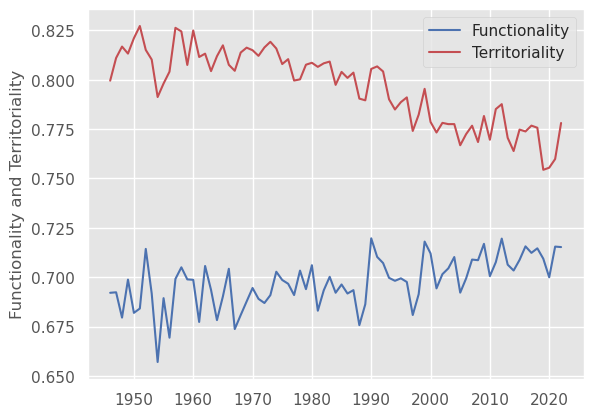

In [26]:
import seaborn as sns 
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# # Add labels to the axes (optional)
ax=sns.lineplot(data=data_human_rights, x="year", y="functionality_w2v_centroid", label='Functionality', color='b')

sns.lineplot(data=data_human_rights, x="year", y="territoriality_w2v_centroid", color='r', label='Territoriality')
ax.set_ylabel('Functionality and Territoriality')
ax.set_xlabel(None)

plt.legend()
# Display the plot
plt.show()

### With Doc2Vec

In [26]:
documents = [TaggedDocument(data_year['clean_text_merged'].iloc[k], [data_year['tag'].iloc[k]]) for k in tqdm(range(len(data_year)))]

model = Doc2Vec(documents, workers=10, vector_size=200, min_count=3, window=20, epochs=5)
fname = f"doc2vec_topic_year.model"
model.save(fname)

100%|██████████| 373/373 [00:00<00:00, 45364.21it/s]


In [27]:
territorial_terms = ['bloc', 'region', 'civilisation', 'country', 'nation']
functional_terms = ['class', 'ideology', 'inequality', 'group', 'social']

fname = f"doc2vec_topic_year.model"

d2v = Doc2Vec.load(fname)
words_frequency = joblib.load('wordscount_preprocess_topic.pkl')

c_territorial_d2v=compute_centroids(d2v, territorial_terms, words_frequency)
c_functional_d2v=compute_centroids(d2v, functional_terms, words_frequency)

100%|██████████| 179878/179878 [00:00<00:00, 3009149.60it/s]


In [85]:
data_economy=data_year[data_year['tag'].str.startswith('Economy')]
data_culture=data_year[data_year['tag'].str.startswith('Culture')]
data_geopolitics=data_year[data_year['tag'].str.startswith('International')]
data_human_rights=data_year[data_year['tag'].str.startswith('Human')]
data_climate=data_year[data_year['tag'].str.startswith('Climate')]

In [49]:
territoriality=[]
functionality=[]
centroids=[]
for speech in data_culture['clean_text_merged'].values:
    speech_centroid= compute_centroids(d2v, speech, words_frequency)
    similarity_territorial = cosine_similarity(speech_centroid, c_territorial)
    similarity_functional= cosine_similarity(speech_centroid, c_functional)
    territoriality.append(similarity_territorial)
    functionality.append(similarity_functional)
    centroids.append(speech_centroid)

100%|██████████| 179878/179878 [00:00<00:00, 2798276.87it/s]


In [50]:
data_culture['territoriality_d2v_centroid']=territoriality
data_culture['speech_d2v_centroid']=centroids
data_culture['functionality_d2v_centroid']=functionality

/tmp/ipykernel_8316/1701406121.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_culture['territoriality_d2v_centroid']=territoriality
/tmp/ipykernel_8316/1701406121.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_culture['speech_d2v_centroid']=centroids
/tmp/ipykernel_8316/1701406121.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

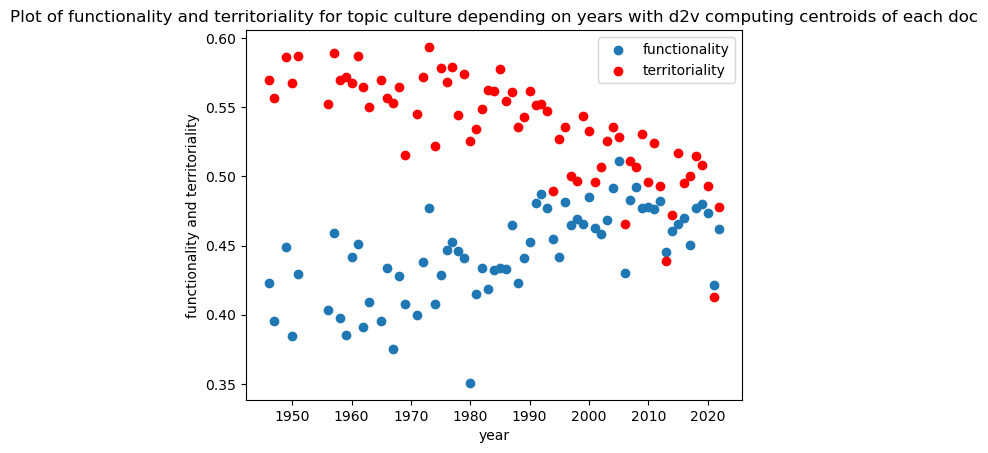

In [51]:
plt.scatter(data_culture['year'], data_culture['functionality_d2v_centroid'], marker='o', label='functionality')
plt.scatter(data_culture['year'], data_culture['territoriality_d2v_centroid'], marker='o', color='r', label='territoriality')

# Set the plot title
plt.title('Plot of functionality and territoriality for topic culture depending on years with d2v computing centroids of each doc')

# Add labels to the axes (optional)
plt.xlabel('year')
plt.ylabel('functionality and territoriality')

plt.legend()
# Display the plot
plt.show()

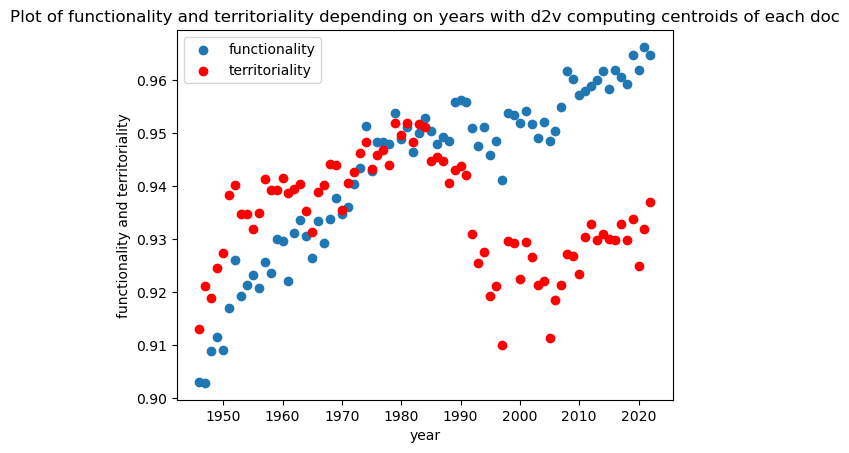

In [14]:
plt.scatter(data_year['year'], data_year['functionality_d2v_centroid'], marker='o', label='functionality')
plt.scatter(data_year['year'], data_year['territoriality_d2v_centroid'], marker='o', color='r', label='territoriality')

# Set the plot title
plt.title('Plot of functionality and territoriality depending on years with d2v computing centroids of each doc')

# Add labels to the axes (optional)
plt.xlabel('year')
plt.ylabel('functionality and territoriality')

plt.legend()
# Display the plot
plt.show()

## Unguided analysis (PCA)

### With Doc2Vec

In [55]:
data_year

,tag,year,topics_name,clean_text_merged,speech_embedding_d2v,PCA_component1_d2v,PCA_component2_d2v
0,Economy_1946,1946,Economy,"[shall, occupy, rostrum, minute, order, genera...","[0.2028572, -1.6156796, 0.15795541, -0.5153398...",NaN,NaN
1,International Relations and Geopolitics_1946,1946,International_Relations_and_Geopolitics,"[colombian_delegation, doe_consider, necessary...","[0.26278618, -5.72294, 0.06466514, -1.7591081,...",NaN,NaN
2,Culture_1946,1946,Culture,"[stand, great, unique_annals, human_history, r...","[0.43342206, -2.5885482, 0.25194702, -0.541804...",NaN,NaN
3,Human Rights and Social Justice_1946,1946,Human_Rights_and_Social_Justice,"[anxious, colleague, consideration, suggestion...","[0.08402115, -0.7922884, 0.06452029, -0.269701...",NaN,NaN
4,Climate Change_1946,1946,Climate_Change,"[cuban_delegation, earnestly_hope, debate, gen...","[0.05677196, -0.27060628, 0.02701496, -0.01822...",NaN,NaN
...,...,...,...,...,...,...,...
368,Climate Change_1963,1963,Climate_Change,"[hall, open, seventeenth_session, general, cli...","[0.1571569, -1.9932014, 0.2651589, -0.45524883...",NaN,NaN
369,Human Rights and Social Justice_1963,1963,Human_Rights_and_Social_Justice,"[president, italian, wish_extend, earnest, con...","[-0.0460254, -2.1722891, 0.34552094, -0.558139...",NaN,NaN
370,International Relations and Geopolitics_1963,1963,International_Relations_and_Geopolitics,"[president_allow, offer_congratulation, electi...","[0.496478, -3.6435578, 0.12464145, -0.93409723...",NaN,NaN
371,Economy_1963,1963,Economy,"[permit_outset, convey_warmest, congratulation...","[0.11606101, -2.6514554, 0.29364106, -0.537757...",NaN,NaN


In [65]:
data_year['speech_embedding_d2v']=data_year['tag'].progress_apply(lambda x: model.dv[x])

100%|██████████| 373/373 [00:00<00:00, 318435.86it/s]
/tmp/ipykernel_8316/1614118269.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_year['speech_embedding_d2v']=data_year['tag'].progress_apply(lambda x: model.dv[x])


In [66]:
data_economy=data_year[data_year['tag'].str.startswith('Economy')]
data_culture=data_year[data_year['tag'].str.startswith('Culture')]
data_geopolitics=data_year[data_year['tag'].str.startswith('International')]
data_human_rights=data_year[data_year['tag'].str.startswith('Human')]
data_climate=data_year[data_year['tag'].str.startswith('Climate')]

## For every topic

/tmp/ipykernel_8316/2577846718.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_year['PCA_component1_d2v']=data_year['tag'].map(pca_comp_1)
/tmp/ipykernel_8316/2577846718.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_year['PCA_component2_d2v']=data_year['tag'].map(pca_comp_2)


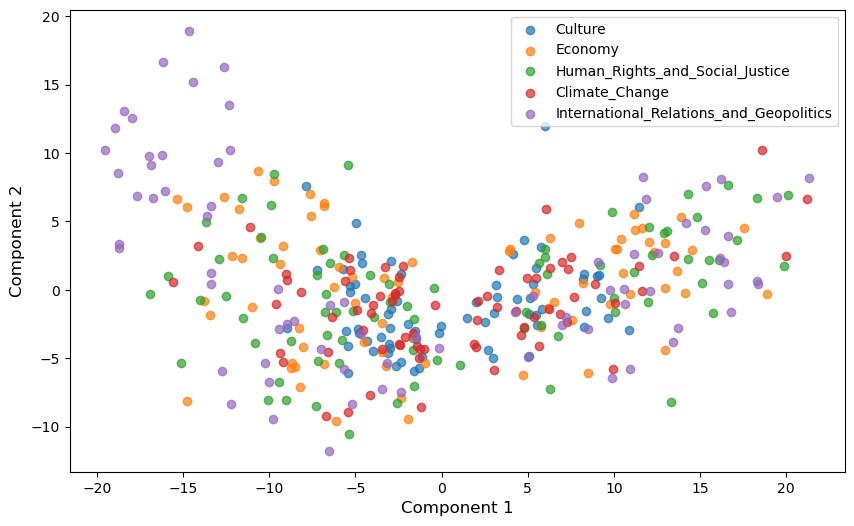

In [58]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# Définir la taille du graphique
fig, ax = plt.subplots(figsize=(10, 6))

# Function to perform PCA
def perform_pca(data):
    # Convert the embeddings to a numpy array
    X = np.array(data['speech_embedding_d2v'].tolist())
    
    # Standardize the data
    X_scaled = scaler.fit_transform(X)
    
    # Perform PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    return pca, X_pca

# Perform PCA on df_main
pca_main, X_pca_main = perform_pca(data_year)

def project_pca(df_subset):
    # X should be a numpy array of shape (n_samples, n_features)
    X_subset = np.array(df_subset['speech_embedding_d2v'].tolist())
    
    # Step 2: Standardize the data
    X_scaled_subset = scaler.transform(X_subset)
    X_pca_subset = pca_main.transform(X_scaled_subset)

    return X_pca_subset

pca_comp_1={}
pca_comp_2={}
for topic in set(data_year['topics_name'].values):
    # Filtrer les données pour la famille actuelle
    data = data_year.loc[data_year['topics_name']==topic].reset_index()
    
    # Obtenir les projections 2D pour les embeddings de la famille actuelle
    projections_2D = project_pca(data)
    for i in range(len(data)):
        row=data.iloc[i]
        tag=row['tag'] 
        comp_1=projections_2D[i][0]
        comp_2=projections_2D[i][1]
        pca_comp_1[tag]=comp_1
        pca_comp_2[tag]=comp_2
    # Créer un graphique en nuage de points pour la famille actuelle
    ax.scatter(projections_2D[:,0], projections_2D[:,1], alpha=0.7, label=topic)
    
data_year['PCA_component1_d2v']=data_year['tag'].map(pca_comp_1)
data_year['PCA_component2_d2v']=data_year['tag'].map(pca_comp_2)

# Définir la taille de la police de caractère pour les étiquettes d'axes
ax.set_xlabel('Component 1', fontsize=12)
ax.set_ylabel('Component 2', fontsize=12)

# Ajouter une légende
ax.legend()
plt.savefig('PCA_whole_corpus_year_d2v.png')
# Afficher le graphique
plt.show()


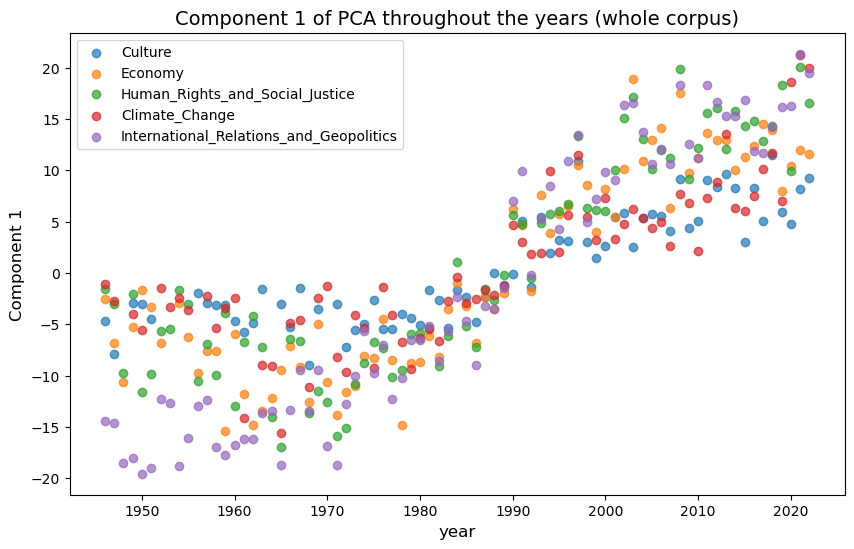

In [61]:
# Définir la taille du graphique
fig, ax = plt.subplots(figsize=(10, 6))
for topic in set(data_year['topics_name'].values):
    # Filtrer les données pour la famille actuelle
    data = data_year.loc[data_year['topics_name']==topic].reset_index()
    ax.scatter(data['year'],data['PCA_component1_d2v'], alpha=0.7, label=topic)
ax.set_title('Component 1 of PCA throughout the years (whole corpus)', fontsize=14)

# Définir la taille de la police de caractère pour les étiquettes d'axes
ax.set_xlabel('year', fontsize=12)
ax.legend()

ax.set_ylabel('Component 1', fontsize=12)
plt.show()

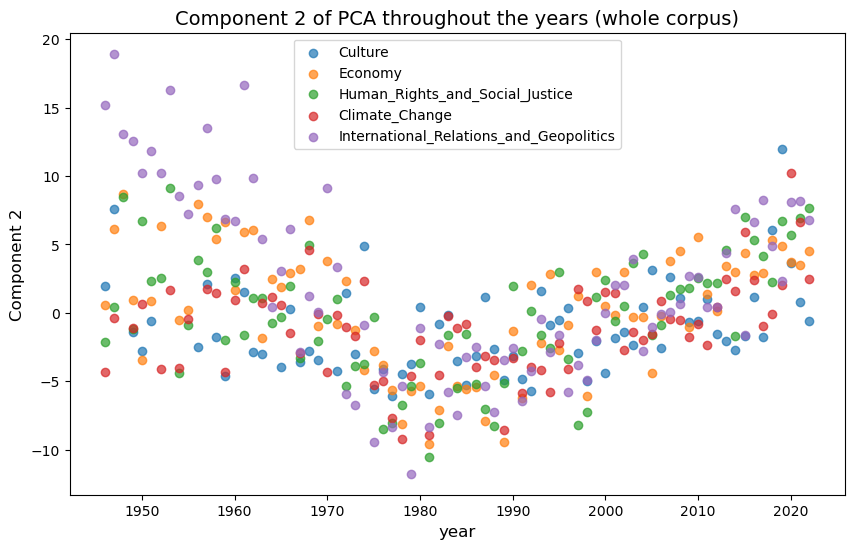

In [62]:
# Définir la taille du graphique
fig, ax = plt.subplots(figsize=(10, 6))
for topic in set(data_year['topics_name'].values):
    # Filtrer les données pour la famille actuelle
    data = data_year.loc[data_year['topics_name']==topic].reset_index()
    ax.scatter(data['year'],data['PCA_component2_d2v'], alpha=0.7, label=topic)
ax.set_title('Component 2 of PCA throughout the years (whole corpus)', fontsize=14)

# Définir la taille de la police de caractère pour les étiquettes d'axes
ax.set_xlabel('year', fontsize=12)
ax.legend()

ax.set_ylabel('Component 2', fontsize=12)
plt.show()

## For one topic

/tmp/ipykernel_8316/2665849565.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data['PCA_component1_d2v']=sub_data['year'].map(pca_comp_1)
/tmp/ipykernel_8316/2665849565.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data['PCA_component2_d2v']=sub_data['year'].map(pca_comp_2)


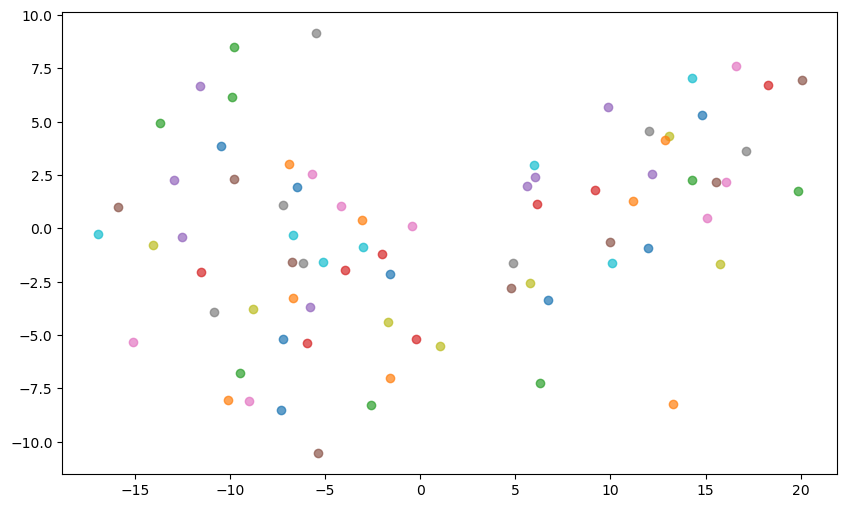

In [82]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# Définir la taille du graphique
fig, ax = plt.subplots(figsize=(10, 6))

# Function to perform PCA
def perform_pca(data):
    # Convert the embeddings to a numpy array
    X = np.array(data['speech_embedding_d2v'].tolist())
    
    # Standardize the data
    X_scaled = scaler.fit_transform(X)
    
    # Perform PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    return pca, X_pca

# Perform PCA on df_main
pca_main, X_pca_main = perform_pca(data_year)

def project_pca(df_subset):
    # X should be a numpy array of shape (n_samples, n_features)
    X_subset = np.array(df_subset['speech_embedding_d2v'].tolist())
    
    # Step 2: Standardize the data
    X_scaled_subset = scaler.transform(X_subset)
    X_pca_subset = pca_main.transform(X_scaled_subset)

    return X_pca_subset

pca_comp_1={}
pca_comp_2={}


sub_data=data_human_rights


for year in set(sub_data['year'].values):
    # Filtrer les données pour la famille actuelle
    data = sub_data.loc[sub_data['year']==year].reset_index()
    
    # Obtenir les projections 2D pour les embeddings de la famille actuelle
    projections_2D = project_pca(data)
    pca_comp_1[year]=(projections_2D[:,0])
    pca_comp_2[year]=(projections_2D[:,1])
    # Créer un graphique en nuage de points pour la famille actuelle
    ax.scatter(projections_2D[:,0], projections_2D[:,1], alpha=0.7, label=year)
    
sub_data['PCA_component1_d2v']=sub_data['year'].map(pca_comp_1)
sub_data['PCA_component2_d2v']=sub_data['year'].map(pca_comp_2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


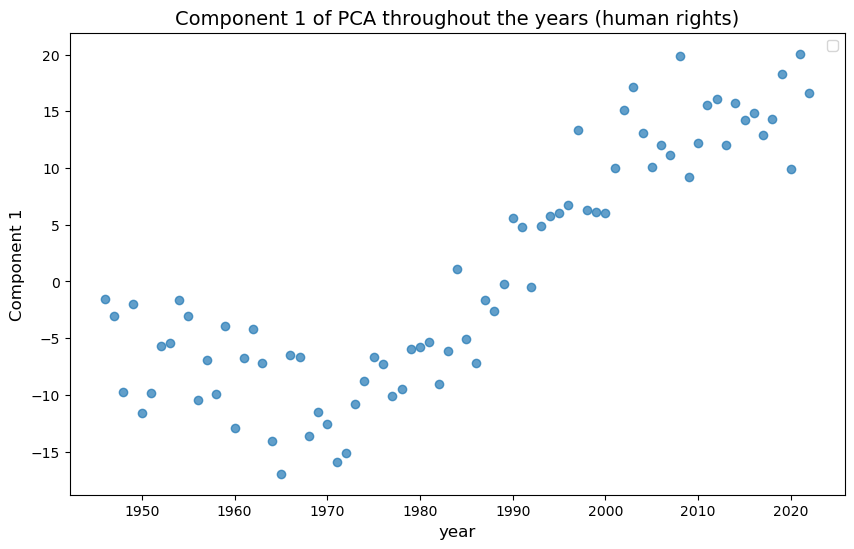

In [83]:
# Définir la taille du graphique
fig, ax = plt.subplots(figsize=(10, 6))
for topic in set(sub_data['topics_name'].values):
    # Filtrer les données pour la famille actuelle
    data = sub_data.loc[sub_data['topics_name']==topic].reset_index()
    ax.scatter(data['year'],data['PCA_component1_d2v'], alpha=0.7)
ax.set_title('Component 1 of PCA throughout the years (human rights)', fontsize=14)

# Définir la taille de la police de caractère pour les étiquettes d'axes
ax.set_xlabel('year', fontsize=12)
ax.legend()

ax.set_ylabel('Component 1', fontsize=12)
plt.show()

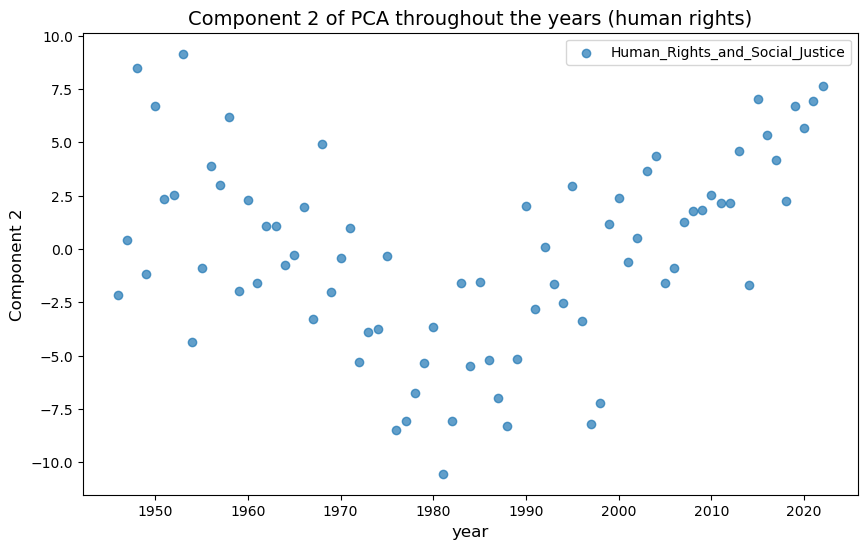

In [84]:
# Définir la taille du graphique
fig, ax = plt.subplots(figsize=(10, 6))
for topic in set(sub_data['topics_name'].values):
    # Filtrer les données pour la famille actuelle
    data = sub_data.loc[sub_data['topics_name']==topic].reset_index()
    ax.scatter(data['year'],data['PCA_component2_d2v'], alpha=0.7, label=topic)
ax.set_title('Component 2 of PCA throughout the years (human rights)', fontsize=14)

# Définir la taille de la police de caractère pour les étiquettes d'axes
ax.set_xlabel('year', fontsize=12)
ax.legend()

ax.set_ylabel('Component 2', fontsize=12)
plt.show()

## For one topic + Word2vec

In [134]:
import joblib
from computing_centroids import compute_centroids
import pickle

sub_data=data_human_rights

sentences = sub_data['clean_text_merged'].values
model = Word2Vec(sentences, vector_size=200, min_count=1, window=20, sg=1)
fname = f"word2vec_topic_year_subdata.model"
model.save(fname)

# Create an empty dictionary for word frequencies
word_freq = {}

# Count word frequencies
for sentence in sentences:
    for word in sentence:
        if word in word_freq:
            word_freq[word] += 1  # Increment count if the word is already in the dictionary
        else:
            word_freq[word] = 1  # Initialize count for new words

# Path to save the pickle file
pickle_file_path = 'wordscount_preprocess_topic_subdata.pkl'

# Open the file in write-binary mode and save the dictionary
with open(pickle_file_path, 'wb') as f:
    pickle.dump(word_freq, f)

territorial_terms = ['bloc', 'region', 'civilisation', 'country', 'nation']
functional_terms = ['class', 'ideology', 'inequality', 'group', 'social']

fname = f"word2vec_topic_year_subdata.model"

w2v = Word2Vec.load(fname)
words_frequency = joblib.load('wordscount_preprocess_topic_subdata.pkl')

c_territorial=compute_centroids(w2v, territorial_terms, words_frequency)
c_functional=compute_centroids(w2v, functional_terms, words_frequency)

100%|██████████| 88939/88939 [00:00<00:00, 3185357.39it/s]


In [135]:
centroids=[]
for speech in sub_data['clean_text_merged'].values:
    speech_centroid= compute_centroids(w2v, speech, words_frequency)
    centroids.append(speech_centroid)
sub_data['speech_w2v_centroid']=centroids

sub_data['pca_w2v_embeddings']=sub_data.apply(lambda x: np.squeeze(x['speech_w2v_centroid']), axis=1)

100%|██████████| 88939/88939 [00:00<00:00, 2409411.94it/s]
/tmp/ipykernel_8316/2708022945.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data['speech_w2v_centroid']=centroids
/tmp/ipykernel_8316/2708022945.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data['pca_w2v_embeddings']=sub_data.apply(lambda x: np.squeeze(x['speech_w2v_centroid']), axis=1)


/tmp/ipykernel_8316/1645406328.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data['PCA_component1_w2v']=sub_data['year'].map(pca_comp_1)
/tmp/ipykernel_8316/1645406328.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data['PCA_component2_w2v']=sub_data['year'].map(pca_comp_2)


Text(0, 0.5, 'Component 2')

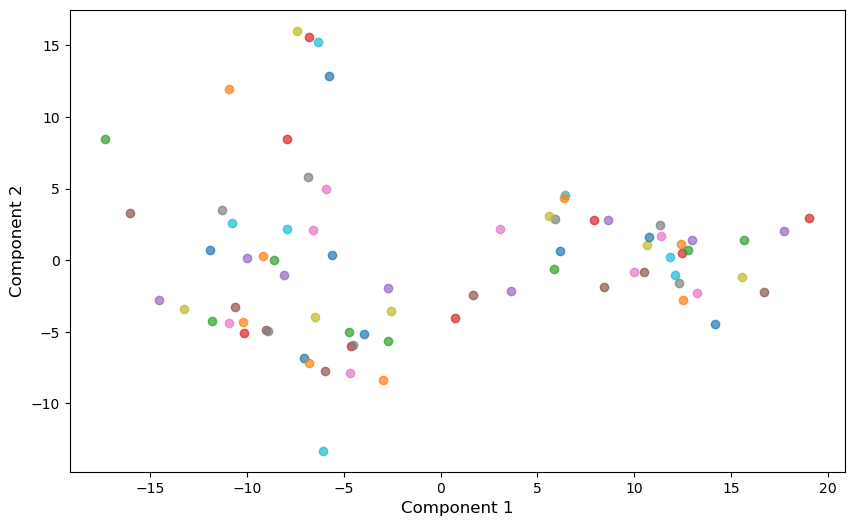

In [136]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# Définir la taille du graphique
fig, ax = plt.subplots(figsize=(10, 6))


# Function to perform PCA
def perform_pca(data):
    # Convert the embeddings to a numpy array
    X = np.array(data['pca_w2v_embeddings'].tolist())
    
    # Standardize the data
    X_scaled = scaler.fit_transform(X)
    
    # Perform PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    return pca, X_pca

# Perform PCA on df_main
pca_main, X_pca_main = perform_pca(sub_data)

def project_pca(data_list):
    # X should be a numpy array of shape (n_samples, n_features)
    X_subset = np.array(data_list)
    
    # Step 2: Standardize the data
    X_scaled_subset = scaler.transform(X_subset)
    X_pca_subset = pca_main.transform(X_scaled_subset)

    return X_pca_subset

pca_comp_1={}
pca_comp_2={}


for year in set(sub_data['year'].values):
    # Filtrer les données pour la famille actuelle
    data = sub_data.loc[sub_data['year']==year].reset_index()
    
    # Obtenir les projections 2D pour les embeddings de la famille actuelle
    projections_2D = project_pca(data['pca_w2v_embeddings'].tolist())
    pca_comp_1[year]=(projections_2D[:,0])
    pca_comp_2[year]=(projections_2D[:,1])
    # Créer un graphique en nuage de points pour la famille actuelle
    ax.scatter(projections_2D[:,0], projections_2D[:,1], alpha=0.7, label=year)
    
sub_data['PCA_component1_w2v']=sub_data['year'].map(pca_comp_1)
sub_data['PCA_component2_w2v']=sub_data['year'].map(pca_comp_2)
    
# Définir la taille de la police de caractère pour les étiquettes d'axes
ax.set_xlabel('Component 1', fontsize=12)
ax.set_ylabel('Component 2', fontsize=12)

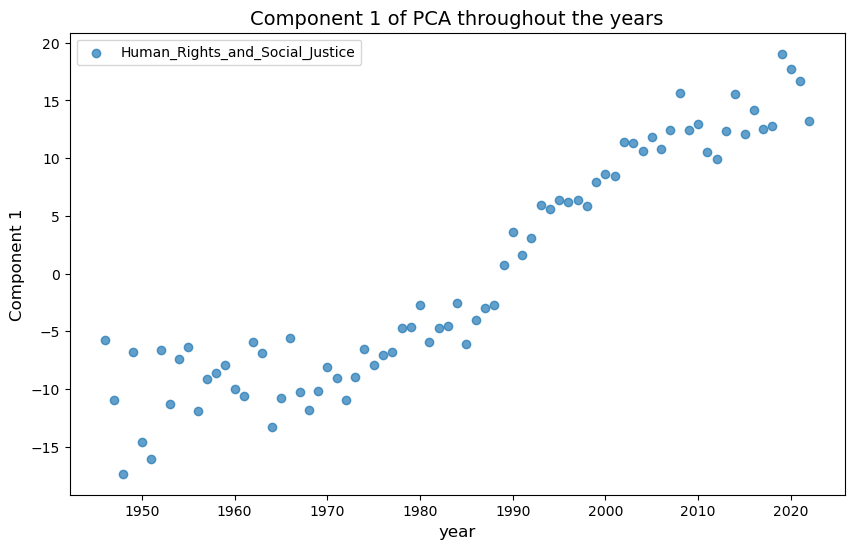

In [137]:
# Définir la taille du graphique
fig, ax = plt.subplots(figsize=(10, 6))
for topic in set(sub_data['topics_name'].values):
    # Filtrer les données pour la famille actuelle
    data = sub_data.loc[sub_data['topics_name']==topic].reset_index()
    ax.scatter(data['year'],data['PCA_component1_w2v'], alpha=0.7, label=topic)
ax.set_title('Component 1 of PCA throughout the years', fontsize=14)

# Définir la taille de la police de caractère pour les étiquettes d'axes
ax.set_xlabel('year', fontsize=12)
ax.legend()

ax.set_ylabel('Component 1', fontsize=12)
plt.show()

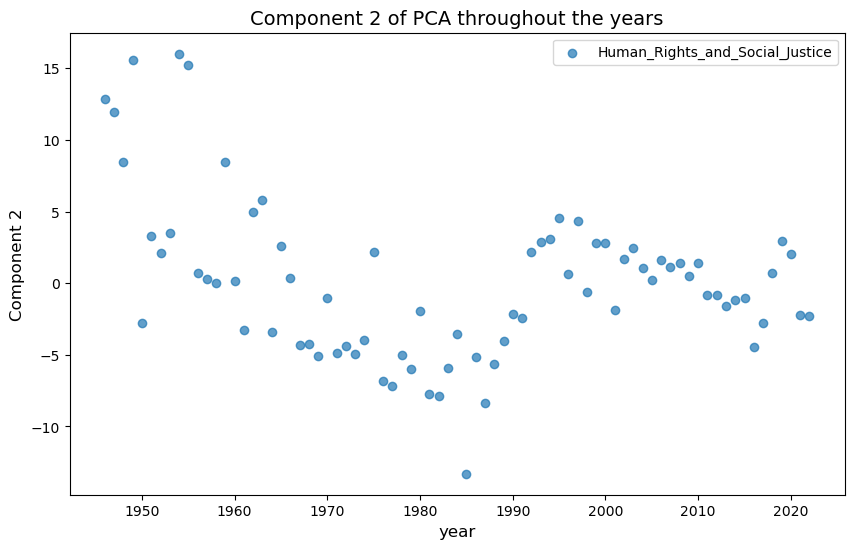

In [138]:
# Définir la taille du graphique
fig, ax = plt.subplots(figsize=(10, 6))
for topic in set(sub_data['topics_name'].values):
    # Filtrer les données pour la famille actuelle
    data = sub_data.loc[sub_data['topics_name']==topic].reset_index()
    ax.scatter(data['year'],data['PCA_component2_w2v'], alpha=0.7, label=topic)
ax.set_title('Component 2 of PCA throughout the years', fontsize=14)

# Définir la taille de la police de caractère pour les étiquettes d'axes
ax.set_xlabel('year', fontsize=12)
ax.legend()

ax.set_ylabel('Component 2', fontsize=12)
plt.show()

In [139]:
model = w2v
list_words=model.wv.index_to_key
list_word_embdeds=[model.wv[word] for word in list_words]
# Extract PCA component 1 scores for all words
word_pca_scores = project_pca(list_word_embdeds)[:, 0]

# Sort words based on PCA component 1 scores in descending order
sorted_word_indices = np.argsort(word_pca_scores)[::-1]
sorted_words = [list_words[i] for i in sorted_word_indices]

# Select top N words with highest PCA component 1 scores
top_n = 20
top_words = sorted_words[:top_n]
print("Top {} words with highest PCA component 1 scores:".format(top_n))
for word in top_words:
    print(word)

Top 20 words with highest PCA component 1 scores:
sdgs
health_care
climate_change
food_security
sids
capacity_building
climate_action
sustainable_development
renewable_energy
implementation_agenda
ldcs
development_partner
girl
gender_equality
emission
pandemic
private_sector
poverty_eradication
sustainable
impact_climate


In [140]:
list_words=model.wv.index_to_key
list_word_embdeds=[model.wv[word] for word in list_words]
# Extract PCA component 1 scores for all words
word_pca_scores = project_pca(list_word_embdeds)[:, 1]

# Sort words based on PCA component 1 scores in descending order
sorted_word_indices = np.argsort(word_pca_scores)[::-1]
sorted_words = [list_words[i] for i in sorted_word_indices]

# Select top N words with highest PCA component 1 scores
top_n = 20
top_words = sorted_words[:top_n]
print("Top {} words with highest PCA component 2 scores:".format(top_n))
for word in top_words:
    print(word)

Top 20 words with highest PCA component 2 scores:
organization
work_organization
secretariat
progress_better
standard_life
second_session
function
membership
agency
working_method
working_group
united_specialized
promote_social
purpose_principle
francisco
larger_freedom
fiftieth_anniversary
charter
increase_membership
efficiency


In [148]:
other_word_embeddings_pca.shape

(179902, 2)

In [145]:
correlations

array([nan])

In [141]:
other_word_embeddings_pca

array([[ -7.02740703,  22.88454979],
       [ 22.54521917, -12.17548215],
       [ 22.22636862, -19.64481061],
       ...,
       [-22.84861202,  -7.48661731],
       [-22.78846139,  -7.51931096],
       [-22.60569968,  -8.41712508]])

## Average similarity of each word embedding with seed vector 

Here we first compute the average embedding of each list of seed words, then the average similarity of the words of the row with the seed vector 

### With Word2Vec

In [25]:
tokenized_corpus = data_year['clean_text_merged'].values
model=w2v
# Seed words

territorial_terms = ['bloc', 'region', 'civilisation', 'country', 'nation']
functional_terms = ['class', 'ideology', 'inequality', 'group', 'social']

seed_words = territorial_terms + functional_terms

# Calculate average vector for seed words
territorial_seed_vectors = sum([model.wv[word] for word in territorial_terms if word in model.wv.index_to_key]) / len(territorial_terms)
functional_seed_vectors = sum([model.wv[word] for word in functional_terms if word in model.wv.index_to_key]) / len(functional_terms)

In [26]:
def cosine_similarity_row(row, ref_vector):
    # Extract vectors for words that are in the model's vocabulary
    word_vectors = np.array(
        [model.wv[word] for word in row if word in model.wv.index_to_key]
    )
    # Calculate cosine similarity for the word vectors against the reference vector
    similarities = cosine_similarity(word_vectors, [ref_vector])
    # Compute the average cosine similarity
    average_similarity = np.mean(similarities)
    return average_similarity

In [27]:
# Calculate cosine similarity between average embeddings and all embedded speeches

data_year['territorial_similarity_w2v'] = data_year['clean_text_merged'].progress_apply(lambda x: cosine_similarity_row(x, territorial_seed_vectors))
data_year['functional_similarity_w2v'] = data_year['clean_text_merged'].progress_apply(lambda x: cosine_similarity_row(x, functional_seed_vectors))

100%|██████████| 77/77 [17:22<00:00, 13.54s/it]
/tmp/ipykernel_2876/1661136397.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_embed['territorial_similarity'] = data_embed['clean_text_merged'].progress_apply(lambda x: cosine_similarity_row(x, territorial_seed_vectors))
100%|██████████| 77/77 [17:24<00:00, 13.57s/it]
/tmp/ipykernel_2876/1661136397.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_embed['functional_similarity'] = data_embed['clean_text_merged'].progress_apply(lambda x: cosine_

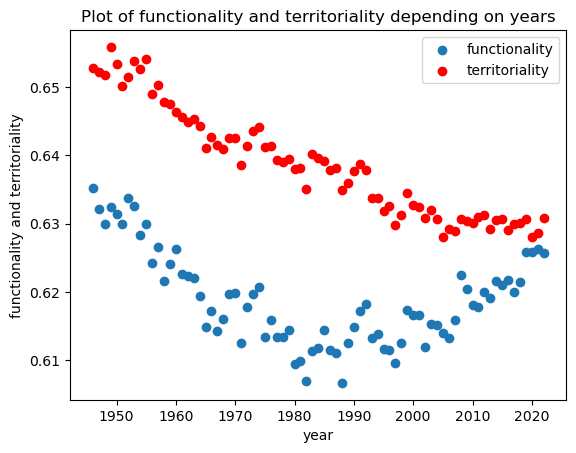

In [28]:
plt.scatter(data_year['year'], data_year['functional_similarity'], marker='o', label='functionality')
plt.scatter(data_year['year'], data_year['territorial_similarity'], marker='o', color='r', label='territoriality')

# Set the plot title
plt.title('Plot of functionality and territoriality depending on years with average similarity and word2vec')

# Add labels to the axes (optional)
plt.xlabel('year')
plt.ylabel('functionality and territoriality')

plt.legend()
# Display the plot
plt.show()

In [31]:
model=w2v

# Calculate semantic similarity between each word in the vocabulary and seed words
word_vectors = {word: model.wv[word] for word in model.wv.index_to_key}
word_similarities = {}

for word, vector in word_vectors.items():
    territorial_similarity = cosine_similarity([vector], [territorial_seed_vectors])[0][0]
    functional_similarity = cosine_similarity([vector], [functional_seed_vectors])[0][0]
    word_similarities[word] = (territorial_similarity, functional_similarity)

In [32]:
sorted_word_similarities = sorted(word_similarities.items(), key=lambda x: (x[1][0]), reverse=True)
top_20_words_territorial = sorted_word_similarities[:30]

top_territorial=[word for word, (func_sim, terr_sim) in top_20_words_territorial[:30]]

print("Top 30 words related to high territorial terms:", top_territorial)

Top 30 words related to high territorial terms: ['destroyed', 'money_spent', 'feed', 'banish', 'unimaginable', 'tentacle', 'disappearing', 'horrible', 'people_died', 'civil_war', 'deadly', 'fast', 'occurring', 'crushing_burden', 'getting', 'leaving', 'sophisticated', 'irrational', 'caught', 'awful', 'shared_prosperity', 'plague', 'poisoned', 'disruption', 'poverty_misery', 'reached_level', 'multiply', 'recruit', 'helpless', 'wind']


In [33]:
sorted_word_similarities = sorted(word_similarities.items(), key=lambda x: (x[1][1]), reverse=True)
top_20_words_functional = sorted_word_similarities[:30]

top_functional=[word for word, (func_sim, terr_sim) in top_20_words_functional[:30]]

print("Top 30 words related to high functional terms:", top_functional)

Top 30 words related to high functional terms: ['crushing_burden', 'shared_prosperity', 'poverty_misery', 'banish', 'protect_environment', 'nascent', 'caring', 'disappearing', 'occurring', 'sophisticated', 'child_dying', 'virus', 'tuberculosis', 'annually', 'luxury', 'hunger_poverty', 'wealthy', 'money_spent', 'suffer_hunger', 'better_health', 'hungry', 'improved_health', 'economic_model', 'fewer', 'unemployed', 'starving', 'heal', 'forgiveness', 'transform_life', 'save_humankind']


### With Doc2Vec

In [24]:
tokenized_corpus = data_year['clean_text_merged'].values
model=d2v
# Seed words

territorial_terms = ['bloc', 'region', 'civilisation', 'country', 'nation']
functional_terms = ['class', 'ideology', 'inequality', 'group', 'social']

seed_words = territorial_terms + functional_terms

# Calculate average vector for seed words
territorial_seed_vectors = sum([model.wv[word] for word in territorial_terms if word in model.wv.index_to_key]) / len(territorial_terms)
functional_seed_vectors = sum([model.wv[word] for word in functional_terms if word in model.wv.index_to_key]) / len(functional_terms)

In [25]:
def cosine_similarity_row(row, ref_vector):
    # Extract vectors for words that are in the model's vocabulary
    word_vectors = np.array(
        [model.wv[word] for word in row if word in model.wv.index_to_key]
    )
    # Calculate cosine similarity for the word vectors against the reference vector
    similarities = cosine_similarity(word_vectors, [ref_vector])
    # Compute the average cosine similarity
    average_similarity = np.mean(similarities)
    return average_similarity

In [26]:
# Calculate cosine similarity between average embeddings and all embedded speeches

data_year['territorial_similarity_d2v'] = data_year['clean_text_merged'].progress_apply(lambda x: cosine_similarity_row(x, territorial_seed_vectors))
data_year['functional_similarity_d2v'] = data_year['clean_text_merged'].progress_apply(lambda x: cosine_similarity_row(x, functional_seed_vectors))

100%|██████████| 77/77 [17:12<00:00, 13.40s/it]


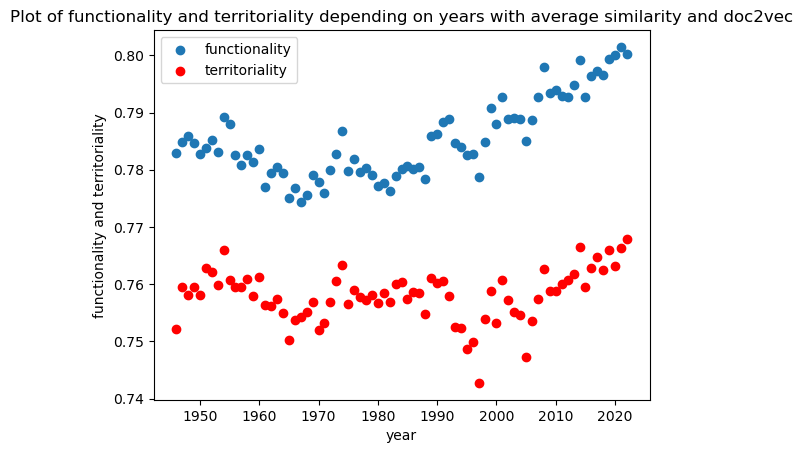

In [27]:
plt.scatter(data_year['year'], data_year['functional_similarity_d2v'], marker='o', label='functionality')
plt.scatter(data_year['year'], data_year['territorial_similarity_d2v'], marker='o', color='r', label='territoriality')

# Set the plot title
plt.title('Plot of functionality and territoriality depending on years with average similarity and doc2vec')

# Add labels to the axes (optional)
plt.xlabel('year')
plt.ylabel('functionality and territoriality')

plt.legend()
# Display the plot
plt.show()

In [28]:
model=d2v

# Calculate semantic similarity between each word in the vocabulary and seed words
word_vectors = {word: model.wv[word] for word in model.wv.index_to_key}
word_similarities = {}

for word, vector in word_vectors.items():
    territorial_similarity = cosine_similarity([vector], [territorial_seed_vectors])[0][0]
    functional_similarity = cosine_similarity([vector], [functional_seed_vectors])[0][0]
    word_similarities[word] = (territorial_similarity, functional_similarity)

In [29]:
sorted_word_similarities = sorted(word_similarities.items(), key=lambda x: (x[1][0]), reverse=True)
top_20_words_territorial = sorted_word_similarities[:30]

top_territorial=[word for word, (func_sim, terr_sim) in top_20_words_territorial[:30]]

print("Top 30 words related to high territorial terms:", top_territorial)

Top 30 words related to high territorial terms: ['grip', 'south_asia', 'establishment_diplomatic', 'especially_true', 'source_tension', 'enclave', 'sided', 'interruption', 'erupted', 'relation_neighbouring', 'emigration', 'salvador', 'indian_ocean', 'danger_posed', 'neighbouring_country', 'poverty_disease', 'central_america', 'breeding_ground', 'consolidated', 'concentrating_effort', 'converting', 'cross_border', 'looming', 'destabilizing', 'unbearable', 'flooding', 'member_association', 'fertilizer', 'privation', 'stability_security']


In [30]:
sorted_word_similarities = sorted(word_similarities.items(), key=lambda x: (x[1][1]), reverse=True)
top_20_words_functional = sorted_word_similarities[:30]

top_functional=[word for word, (func_sim, terr_sim) in top_20_words_functional[:30]]

print("Top 30 words related to high functional terms:", top_functional)

Top 30 words related to high functional terms: ['natural_resource', 'science', 'main_goal', 'beneficiary', 'develop', 'information_technology', 'dividend', 'domestic', 'rich', 'decrease', 'translated', 'right_track', 'scale', 'social_condition', 'alike', 'money', 'deficit', 'national_economy', 'healthy', 'growing', 'compensate', 'discriminatory', 'link', 'ethnic_cultural', 'malnutrition', 'enormous', 'barrier', 'fostered', 'doe_lead', 'grow']


## Guided projections territoriality-functionality

### D2V

Text(0.5, 1.0, 'Projection of Speeches onto territoriality-functionality axis (y_low : territoriality, y_high : functionality)')

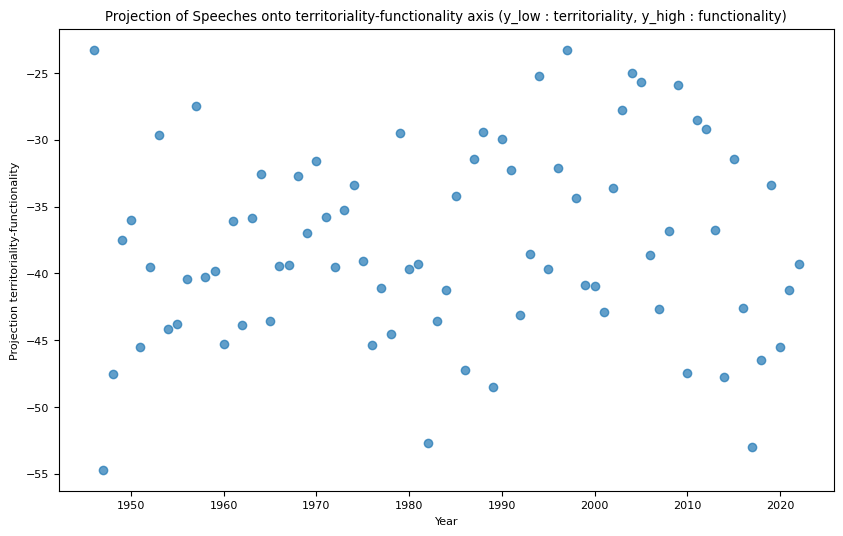

In [106]:
model=d2v

lex = [territorial_terms, functional_terms] 

def linear_projection_1D(pVec, vecXLeft, vecXRight):    
    vecX = vecXRight.mean(axis=0) - vecXLeft.mean(axis=0) 
    return np.dot(pVec, vecX)  

def get_vector(model, words, num_features=200): 
    words = [w for w in words if w in model.wv.index_to_key]
    L = len(words)
    temp = np.zeros((L, num_features))
    for i, x in enumerate(words):
        temp[i,:] = model.wv[x]
    return temp

def custom_projection_1D(z, model):
    M = model.vector_size
    x_terr, x_func = [get_vector(model, words, M) for words in lex] 
    projections = [linear_projection_1D(x, x_terr, x_func) for x in z]
    Z = np.array(projections) 
    return Z

# Définir la taille de la police de caractère
plt.rcParams.update({'font.size': 8})

# Trier les données par année
df_sorted = data_year.sort_values(by=['year'])

# Définir la taille du graphique
fig, ax = plt.subplots(figsize=(10, 6))

projections_1D = custom_projection_1D(df_sorted['speech_embedding_d2v'].values, model)

# Créer un graphique en nuage de points pour la famille actuelle
ax.scatter(df_sorted['year'], projections_1D, alpha=0.7)

# Label the axes
plt.xlabel("Year")
plt.ylabel("Projection territoriality-functionality")
plt.title("Projection of Speeches onto territoriality-functionality axis (y_low : territoriality, y_high : functionality)")

### W2V

Text(0.5, 1.0, 'Projection of Speeches onto territoriality-functionality axis (y_low : territoriality, y_high : functionality)')

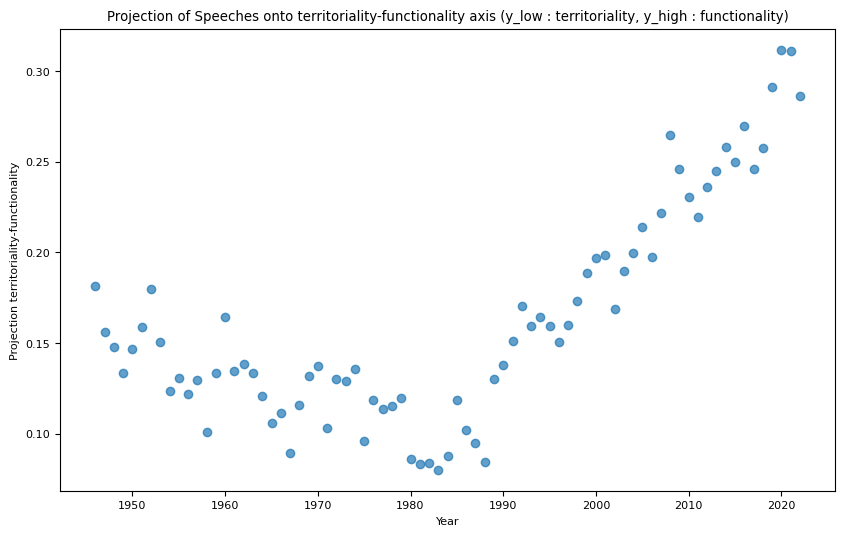

In [109]:
model=w2v

lex = [territorial_terms, functional_terms] 

# Définir la taille de la police de caractère
plt.rcParams.update({'font.size': 8})

# Trier les données par année
df_sorted = data_year.sort_values(by=['year'])

# Définir la taille du graphique
fig, ax = plt.subplots(figsize=(10, 6))

projections_1D = custom_projection_1D(df_sorted['speech_w2v_centroid'].values, model)

# Créer un graphique en nuage de points pour la famille actuelle
ax.scatter(df_sorted['year'], projections_1D, alpha=0.7)

# Label the axes
plt.xlabel("Year")
plt.ylabel("Projection territoriality-functionality")
plt.title("Projection of Speeches onto territoriality-functionality axis (y_low : territoriality, y_high : functionality)")

In [ ]:
import numpy as np
import pandas as pd
from gensim.models.doc2vec import Doc2Vec
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances


def topic_vectors(topicwords, model, n=20):
    M = model.vector_size
    centroids = []

    # Compute the centroid for each topic word and store them in a list
    for topicword in topicwords:
        sims = model.wv.most_similar(topicword, topn=n)
        simw = [topicword] + [w for w, s in sims]
        zsim = np.zeros((n + 1, M))
        for i, w in enumerate(simw):
            zsim[i, :] = model.wv[w]
        centroids.append(zsim.mean(axis=0))

    # Calculate the average centroid across all topic words
    overall_centroid = np.mean(centroids, axis=0)
    return overall_centroid

def bootstrap_topic_vectors(topicwords, model, n=20, sims=1000):
    M = model.vector_size
    boot_results = np.zeros((sims, M))
    
    # Get all topic words to be used in bootstrapping
    topic_words = []
    for topicword in topicwords:
        expanded_word_list = model.wv.most_similar(topicword, topn=n - 1)
        topic_words.extend([topicword] + [w for w, s in expanded_word_list])
    
    # Perform bootstrapping to calculate centroids
    for s in range(sims):
        boot_sample = np.random.choice(topic_words, size=n, replace=True)
        zsim = np.zeros((n, M))
        for i, w in enumerate(boot_sample):
            zsim[i, :] = model.wv[w]
        boot_results[s, :] = zsim.mean(axis=0)

    return boot_results

def cos_sim(speech, topic, boot=True, sims=1000):
    P = speech.shape[0]
    if boot:
        C = cosine_similarity(speech, topic)
        m = np.mean(C, axis=1)
        ci = np.percentile(C, q=[2.5, 97.5], axis=1)
        return m.tolist(), ci[0].tolist(), ci[1].tolist()
    else:
        return cosine_similarity(speech, topic).tolist()

def issue_ownership(model, topicwords, infer_vector=True, t_size=20, boot=True, smooth=True):
    # Get the average centroid for the list of topic words
    if infer_vector:
        if boot:
            t = bootstrap_topic_vectors(topicwords, model, n=t_size, sims=1000)
        else:
            t = topic_vectors(topicwords, model, n=t_size)
    else:
        raise ValueError("Either topic words or topic vectors must be provided")

    res = fit(model, t, smooth=smooth, boot=boot)
    return res

def fit(model, topic_vector, smooth=False, boot=True):
    M = model.vector_size
    years = sorted(list(set(data_embed['year'].values)))
    P = len(years)
    z = np.zeros((P, M))

    # Populate `z` with document vectors for each year
    for i, year in enumerate(years):
        doc_index = next((index for (index, (doc, tag)) in enumerate(documents) if tag == [year]), None)
        if doc_index is not None:
            z[i, :] = model.dv[doc_index]
    
    # Calculate similarity and return results
    C = cos_sim(z, topic_vector, boot=boot)
    res = pd.DataFrame({'year': years, 'similarity': C[0]})

    if smooth:
        res = res.rolling(window=10, center=False).mean()
        res['year'] = years

    return res


In [ ]:
sims = model.wv.most_similar('territorial', topn = 10)
sims

In [ ]:
corpus_trends=pd.DataFrame()
corpus_functional_sim=issue_ownership(model, topicwords=functional_terms, smooth=False, boot=True)
corpus_territorial_sim=issue_ownership(model, topicwords=territorial_terms, smooth=False, boot=True)

corpus_trends['year']=corpus_functional_sim['year']
corpus_trends['functionality']=corpus_functional_sim['similarity']
corpus_trends['territoriality']=corpus_territorial_sim['similarity']
plt.plot(corpus_trends['year'], corpus_trends['functionality'], marker='o', label='functionality')
plt.plot(corpus_trends['year'], corpus_trends['territoriality'], marker='o', color='r', label='territoriality')

# Set the plot title
plt.title('Plot of functionality and territoriality depending on years')

# Add labels to the axes (optional)
plt.xlabel('year')
plt.ylabel('functionality and territoriality')

plt.legend()
# Display the plot
plt.show()